In [4]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import urllib.request
import matplotlib.pyplot as plt
import cv2

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

import os
from shutil import copyfile
import random

In [42]:
# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import json
import random
from shutil import copyfile
#from google.colab import drive
#drive.mount('/content/drive')

ImportError: Traceback (most recent call last):
  File "/Users/nesara/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 18, in swig_import_helper
    fp, pathname, description = imp.find_module('_pywrap_tensorflow_internal', [dirname(__file__)])
  File "/Users/nesara/anaconda3/lib/python3.6/imp.py", line 297, in find_module
    raise ImportError(_ERR_MSG.format(name), name=name)
ImportError: No module named '_pywrap_tensorflow_internal'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/nesara/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/Users/nesara/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/Users/nesara/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 20, in swig_import_helper
    import _pywrap_tensorflow_internal
ModuleNotFoundError: No module named '_pywrap_tensorflow_internal'


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

# Dataset

In [ ]:
# Label hierarchy
dfh = pd.read_json("data/bbox_labels_600_hierarchy.json")

# label id to name mapping
bbox_id_name = pd.read_csv("data/class-descriptions-boxable.csv", header=None)
bbox_id_name.columns = ["label_id", "label_name"]

with open("data/open_images_segmentation_classes.txt", "r") as f:
    seg_id = f.read().split("\n")
seg_id_names = bbox_id_name[bbox_id_name["label_id"].isin(seg_id)]

#### Get list of all furniture and clothing label id and names

In [79]:
# Get classes under furniture and clothing
#furniture_id = bbox_id_name[bbox_id_name["label_name"]=="Furniture"]["label_id"].values[0]
#clothing_id = bbox_id_name[bbox_id_name["label_name"]=="Clothing"]["label_id"].values[0]

# Furniture classes
furniture_category = dfh.iloc[13]["Subcategory"]["Subcategory"] #13: Furniture
furniture_id = []
for j in range(len(furniture_category)):
    furniture_id.append(furniture_category[j]["LabelName"])
    if "Subcategory" in furniture_category[j]:
        for l in range(len(furniture_category[j]["Subcategory"])):
            furniture_id.append(furniture_category[j]["Subcategory"][l]["LabelName"])
furniture_id_name = bbox_id_name[bbox_id_name["label_id"].isin(furniture_id)]
furniture_id_name

# Clothing classes
clothing_category = dfh.iloc[43]["Subcategory"]["Subcategory"] #43: Clothing
clothing_id = []
for j in range(len(clothing_category)):
    clothing_id.append(clothing_category[j]["LabelName"])
    if "Subcategory" in clothing_category[j]:
        for l in range(len(clothing_category[j]["Subcategory"])):
            clothing_id.append(clothing_category[j]["Subcategory"][l]["LabelName"])
clothing_id_name = bbox_id_name[bbox_id_name["label_id"].isin(clothing_id)]

#### Get list of furniture and clothing labels which are segmentated in open images

In [80]:
# List of furniture labels which are segmented
furniture_seg_id_names = seg_id_names[seg_id_names["label_id"].isin(furniture_id_name["label_id"])]
furniture_seg_id_names

,label_id,label_name
140,/m/026qbn5,Studio couch
153,/m/02crq1,Couch
245,/m/03m3pdh,Sofa bed
278,/m/047j0r,Filing cabinet
329,/m/05kyg_,Chest of drawers
367,/m/0703r8,Loveseat


In [81]:
# List of clothing labels which are segmented
clothing_seg_id_names = seg_id_names[seg_id_names["label_id"].isin(clothing_id_name["label_id"])]
clothing_seg_id_names

,label_id,label_name
31,/m/0174n1,Glove
33,/m/0176mf,Belt
38,/m/01940j,Backpack
44,/m/01b638,Boot
47,/m/01bfm9,Shorts
55,/m/01cmb2,Miniskirt
57,/m/01d40f,Dress
70,/m/01gkx_,Swimwear
97,/m/01n4qj,Shirt
100,/m/01nq26,Sock


## Classes and colors

In [2]:
def create_pascal_label_colormap():
    """Creates a label colormap used in PASCAL VOC segmentation benchmark.

    Returns:
    A Colormap for visualizing segmentation results.
    """
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
    label: A 2D array with integer type, storing the segmentation label.

    Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

    Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_pascal_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


LABEL_NAMES = np.asarray([
    'background', 'couch', 'chair', 'bed', 'vase', 'bowl', 'cup',
    'wine glass', 'potted plant'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

# Scraping

In [6]:
class_list = ["couch", "chair", "bed", "bowl", "cup", "vase", "wine-glass", "potted-plant"];
image_id = 0
for cl in class_list:
    print(cl)
    pottery_barn_sofa_page_content = "../../vision/data/pb_"+cl+".html"
    with open(pottery_barn_sofa_page_content) as fp:
        soup = BeautifulSoup(fp, 'lxml')

    imgs = soup.findAll("img", {"class":"hoverSwap"})
    for i in range(len(imgs)):
        image_url = imgs[i]["src"]
        src = "../../vision/classwise_product_imgs/"+cl+"/"+str(image_id).zfill(3)+".jpg"
        dest = "../../vision/segmentation_dataset/JPEGImages/"+str(image_id).zfill(3)+".jpg"
        urllib.request.urlretrieve(image_url, src)
        copyfile(src, dest);
        image_id += 1

couch
chair
bed
bowl
cup
vase
wine-glass
potted-plant


### Create train and test datasets using images and masks

In [40]:
random.seed(100)
path_images = "../../vision/segmentation_dataset/confidence_0.75/JPEGImages/"
path_masks = "../../vision/segmentation_dataset/confidence_0.75/SegmentationClass/"

# List of all images
all_images = []
image_ids = []
for f in os.listdir(path_images):
    #all_images.append(path_images + f)
    image_ids.append(int(f.split(".jpg")[0]))

# List of all masks
all_masks = []
mask_ids = []
for f in os.listdir(path_masks):
    #all_masks.append(path_masks + f)
    mask_ids.append(int(f.split(".jpg")[0]))

# Check if number of images and masks are the same
if len(image_ids) == len(mask_ids):
    print("Number of images  = Number of masks")
else:
    print("Error: Number of images != Number of masks")

    
# Train, validation, test dataset splits
total_images = len(image_ids)
train_split = 0.60
val_split = 0.20
test_split = 0.20

num_train = int(np.round(total_images * train_split))
num_val = int(np.round(total_images * val_split))
num_test = int(total_images - num_train - num_val)

print("Total number of images: " + str(total_images))
print("Total number of train images: " + str(num_train))
print("Total number of val images: " + str(num_val))
print("Total number of test images: " + str(num_test))

if (total_images == (num_train + num_val + num_test)):
    print("total_images = (num_train + num_val + num_test)")
else:
    print("total_images != (num_train + num_val + num_test)")


# Shuffle images and masks
random_image_order = image_ids
random.shuffle(random_image_order)


# Split dataset into training, validation and test sets
train_list = []
val_list = []
test_list = []
for i in range(total_images):
    im = {}
    im["image"] = path_images + str(random_image_order[i]) + ".jpg"
    im["segmentation_mask"] = path_masks + str(random_image_order[i]) + ".jpg"
    
    if (i < num_train):
        train_list.append(im)
    elif (i >= num_train and i < num_train+num_val):
        val_list.append(im)
    else:
        test_list.append(im)
        
if len(train) != num_train:
    print("Number of training images != num_train")
if len(val) != num_val:
    print("Number of validation images != num_val")
if len(test) != num_test:
    print("Number of test images != num_test")

Number of images  = Number of masks
Total number of images: 476
Total number of train images: 286
Total number of val images: 95
Total number of test images: 95
total_images = (num_train + num_val + num_test)


## Color spaces

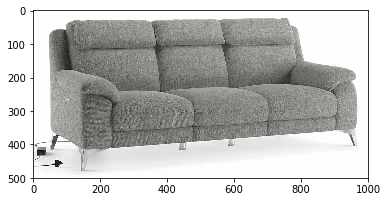

In [32]:
im = cv2.imread('../../vision/data/sofa3.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
plt.show()

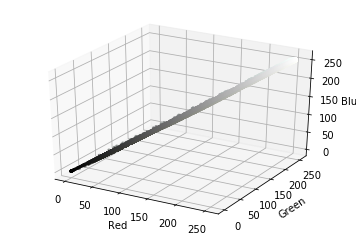

In [33]:
# RGB color space
r, g, b = cv2.split(im)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = im.reshape((np.shape(im)[0]*np.shape(im)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

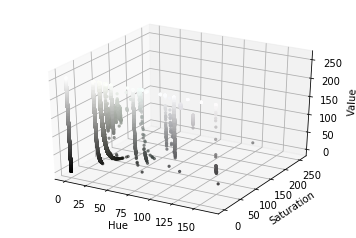

In [34]:
hsv_im = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv_im)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()